In [1]:
# 1. Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import joblib  # untuk menyimpan model

%matplotlib inline


In [2]:
df = pd.read_csv('banjir.csv')
df.head()

,periode_data,jumlah_luka_ringan,jumlah_pengungsi_tertinggi,jumlah_tempat_pengungsian,nilai_kerugian,kota_administrasi,kecamatan,kelurahan,rw,jumlah_terdampak_rw,jumlah_terdampak_rt,jumlah_terdampak_kk,jumlah_terdampak_jiwa,ketinggian_air,tanggal_kejadian,lama_genangan,jumlah_meninggal,jumlah_hilang,jumlah_luka_berat
0,202001,1208,10,0,0,Jakarta Barat,KALIDERES,TEGAL ALUR,"RW 03, 04, 11, 12, 15",5,5,302,1208,31 s/d 150 cm,tgl. 01 Januari,0,0,0,0
1,202001,130,4,0,0,Jakarta Barat,KEBON JERUK,DURI KEPA,"'RW 02, 03, 04, 05, 09, 13, 14",7,7,60,130,31 s/d 70 cm,tgl. 01 Januari,0,0,0,0
2,202001,36,1,0,0,Jakarta Barat,KEBON JERUK,KEDOYA SELATAN,"RW 01, 04, 05",3,3,9,36,10 s/d 150 cm,"tgl. 01, 27 Januari",0,0,0,0
3,202001,1238,15,0,0,Jakarta Barat,KEBON JERUK,KEDOYA UTARA,"RW 02, 04, 05",3,3,309,1238,31 s/d 100 cm,tgl. 01 Januari,0,0,0,0
4,202001,0,0,0,0,Jakarta Barat,KEBON JERUK,SUKABUMI UTARA,"RW 01, 03, 04, 07, 08, 10, 11",7,7,0,0,10 s/d 140 cm,"tgl. 01, 18 Januari",0,0,0,0


/tmp/ipython-input-389656783.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tanggal_kejadian'] = pd.to_datetime(df['tanggal_kejadian'], errors='coerce')


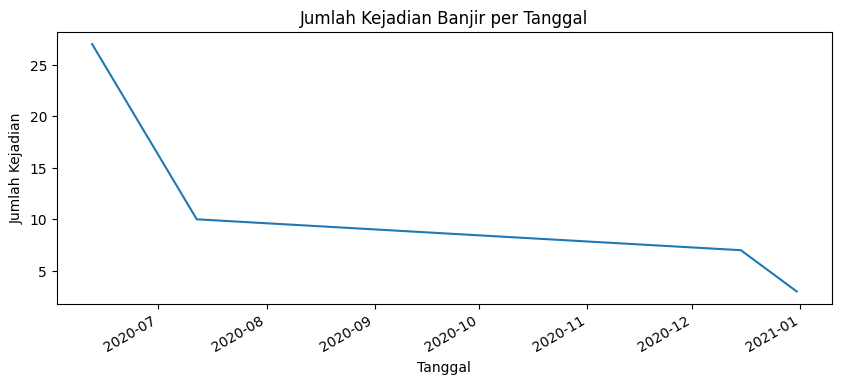

In [3]:
df['tanggal_kejadian'] = pd.to_datetime(df['tanggal_kejadian'], errors='coerce')

kejadian_per_tanggal = df.groupby('tanggal_kejadian').size()

plt.figure(figsize=(10,4))
kejadian_per_tanggal.plot()
plt.title("Jumlah Kejadian Banjir per Tanggal")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Kejadian")
plt.show()


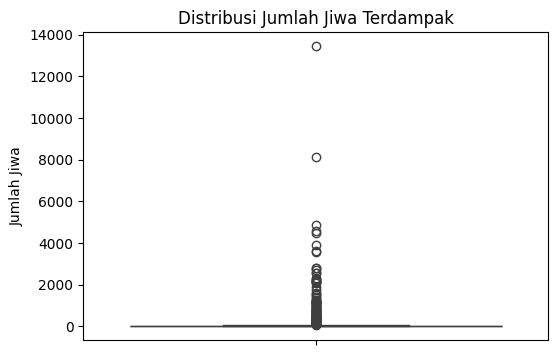

In [6]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['jumlah_terdampak_jiwa'])
plt.title("Distribusi Jumlah Jiwa Terdampak")
plt.ylabel("Jumlah Jiwa")
plt.show()


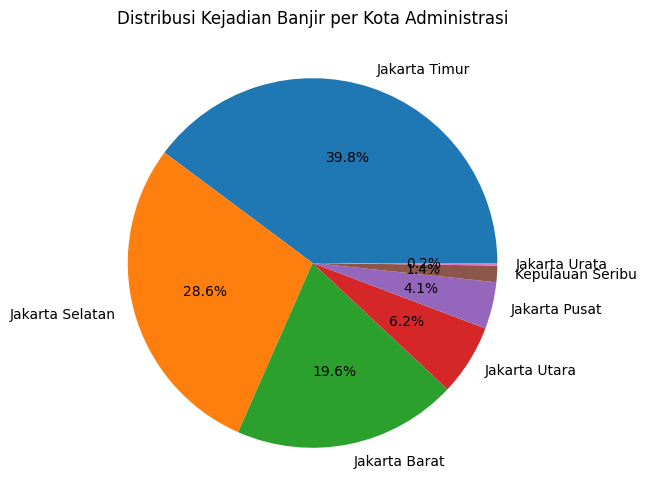

In [7]:
kota_count = df['kota_administrasi'].value_counts()

plt.figure(figsize=(6,6))
kota_count.plot.pie(autopct='%1.1f%%')
plt.title("Distribusi Kejadian Banjir per Kota Administrasi")
plt.ylabel("")
plt.show()


In [4]:
df.nunique()

,0
periode_data,11
jumlah_luka_ringan,136
jumlah_pengungsi_tertinggi,23
jumlah_tempat_pengungsian,4
nilai_kerugian,1
kota_administrasi,7
kecamatan,46
kelurahan,220
rw,345
jumlah_terdampak_rw,15


In [12]:
df['jumlah_terdampak_kk'].unique()[:20]


array(['302', '60', '9', '309', '0', '177', '240', '4', '75', '16', '23',
       '33', '87', '37', '91', '122', '43', '10', '13', '24'],
      dtype=object)

In [14]:
df['jumlah_terdampak_kk'] = (
    df['jumlah_terdampak_kk']
    .astype(str)           # pastikan string
    .str.strip()           # hapus spasi kiri-kanan
    .replace('', np.nan)   # string kosong jadi NaN
)

df['jumlah_terdampak_kk'] = pd.to_numeric(
    df['jumlah_terdampak_kk'],
    errors='coerce'
).fillna(0).astype(int)


In [15]:
df['jumlah_terdampak_kk'].dtype


dtype('int64')

In [5]:
df['ketinggian_air'].head(10)


,ketinggian_air
0,31 s/d 150 cm
1,31 s/d 70 cm
2,10 s/d 150 cm
3,31 s/d 100 cm
4,10 s/d 140 cm
5,30 s/d 100 cm
6,60 cm
7,31 s/d 150 cm
8,31 s/d 120 cm
9,30 s/d 90 cm


In [6]:
import re

def clean_ketinggian_air(value):
    if pd.isna(value):
        return 0
    # Ambil semua angka dalam teks
    numbers = re.findall(r'\d+', str(value))
    if len(numbers) == 0:
        return 0
    # Ambil nilai maksimum (cm)
    return max(map(int, numbers))


In [7]:
df['ketinggian_air_cm'] = df['ketinggian_air'].apply(clean_ketinggian_air)


In [8]:
df[['ketinggian_air', 'ketinggian_air_cm']].head(15)


,ketinggian_air,ketinggian_air_cm
0,31 s/d 150 cm,150
1,31 s/d 70 cm,70
2,10 s/d 150 cm,150
3,31 s/d 100 cm,100
4,10 s/d 140 cm,140
5,30 s/d 100 cm,100
6,60 cm,60
7,31 s/d 150 cm,150
8,31 s/d 120 cm,120
9,30 s/d 90 cm,90


In [8]:
bins = [0, 50, 100, 300]
labels = ['Rendah', 'Sedang', 'Tinggi']
df['kategori_ketinggian'] = pd.cut(df['ketinggian_air_cm'], bins=bins, labels=labels)

kategori_count = df['kategori_ketinggian'].value_counts()

plt.figure(figsize=(6,6))
kategori_count.plot.pie(autopct='%1.1f%%')
plt.title("Proporsi Kategori Ketinggian Air")
plt.ylabel("")
plt.show()


KeyError: 'ketinggian_air_cm'

In [17]:
fitur = [
    'ketinggian_air_cm',
    'jumlah_terdampak_rt',
    'jumlah_terdampak_kk',
    'jumlah_terdampak_jiwa',
    'jumlah_pengungsi_tertinggi'
]

X = df[fitur].fillna(0)


In [18]:
X.dtypes


,0
ketinggian_air_cm,int64
jumlah_terdampak_rt,int64
jumlah_terdampak_kk,int64
jumlah_terdampak_jiwa,int64
jumlah_pengungsi_tertinggi,int64


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


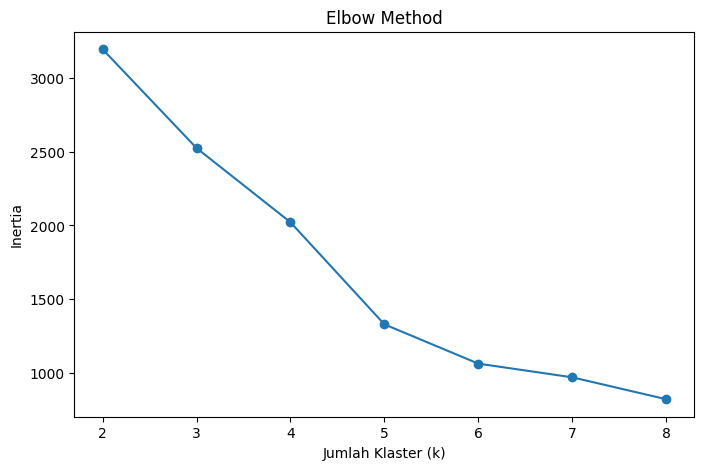

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 9), inertia, marker='o')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [21]:
from sklearn.metrics import silhouette_score

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'k={k}, Silhouette Score={score:.3f}')


k=2, Silhouette Score=0.743
k=3, Silhouette Score=0.572
k=4, Silhouette Score=0.537
k=5, Silhouette Score=0.544
k=6, Silhouette Score=0.553
k=7, Silhouette Score=0.542
k=8, Silhouette Score=0.522


In [22]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [23]:
df.groupby('cluster')[fitur].mean()


,ketinggian_air_cm,jumlah_terdampak_rt,jumlah_terdampak_kk,jumlah_terdampak_jiwa,jumlah_pengungsi_tertinggi
cluster,,,,,
0,124.322034,18.118644,526.898305,1861.677966,14.491525
1,58.463820,2.659549,13.425860,49.141163,0.565836


In [25]:
cluster_label = {
    0: 'Banjir Berat',
    1: 'Banjir Ringan'
}

df['kategori_banjir'] = df['cluster'].map(cluster_label)


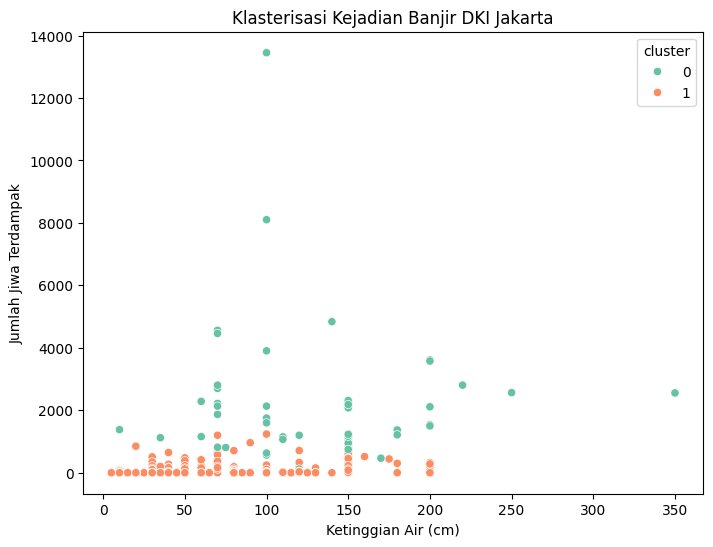

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df['ketinggian_air_cm'],
    y=df['jumlah_terdampak_jiwa'],
    hue=df['cluster'],
    palette='Set2'
)
plt.title('Klasterisasi Kejadian Banjir DKI Jakarta')
plt.xlabel('Ketinggian Air (cm)')
plt.ylabel('Jumlah Jiwa Terdampak')
plt.show()


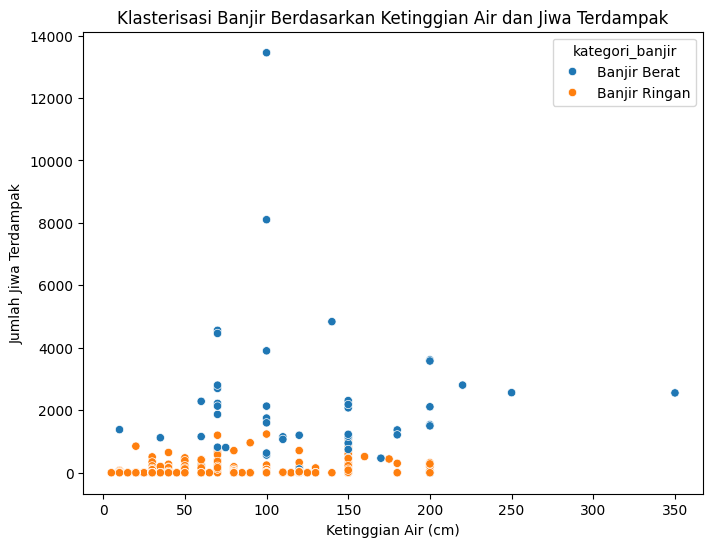

In [27]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='ketinggian_air_cm',
    y='jumlah_terdampak_jiwa',
    hue='kategori_banjir'
)
plt.title('Klasterisasi Banjir Berdasarkan Ketinggian Air dan Jiwa Terdampak')
plt.xlabel('Ketinggian Air (cm)')
plt.ylabel('Jumlah Jiwa Terdampak')
plt.show()


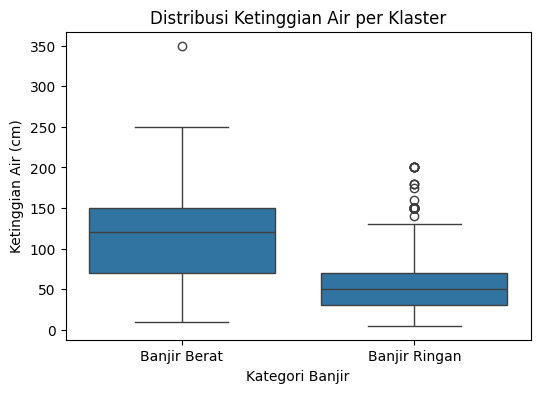

In [28]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x='kategori_banjir',
    y='ketinggian_air_cm'
)
plt.title('Distribusi Ketinggian Air per Klaster')
plt.xlabel('Kategori Banjir')
plt.ylabel('Ketinggian Air (cm)')
plt.show()


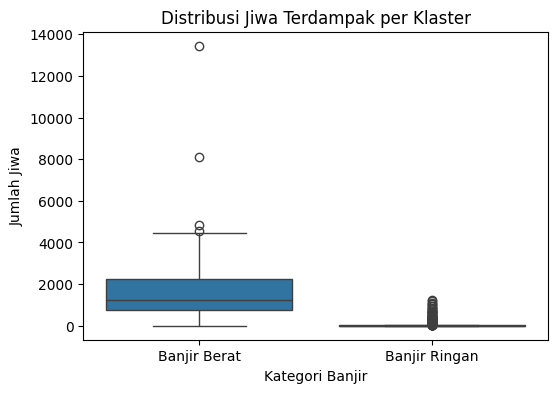

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x='kategori_banjir',
    y='jumlah_terdampak_jiwa'
)
plt.title('Distribusi Jiwa Terdampak per Klaster')
plt.xlabel('Kategori Banjir')
plt.ylabel('Jumlah Jiwa')
plt.show()


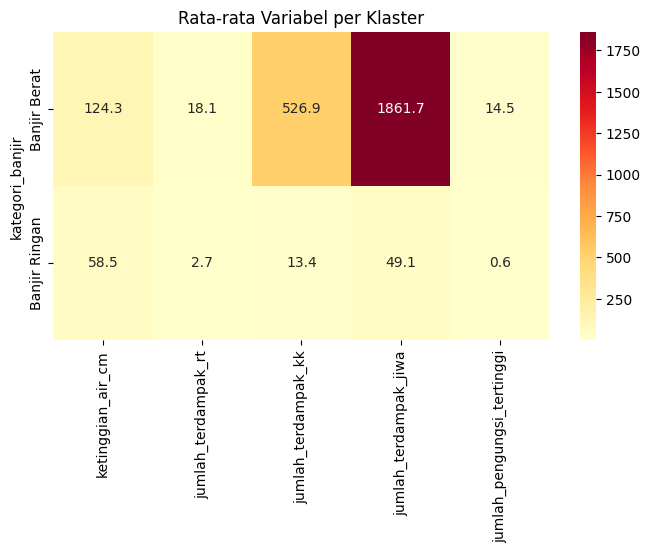

In [31]:
plt.figure(figsize=(8,4))
sns.heatmap(
    cluster_mean,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd'
)
plt.title('Rata-rata Variabel per Klaster')
plt.show()


In [32]:
agregasi_kelurahan = (
    df.groupby('kelurahan')
    .agg(
        total_kejadian=('kategori_banjir', 'count'),
        banjir_berat=('kategori_banjir', lambda x: (x == 'Banjir Berat').sum()),
        rata_ketinggian_air=('ketinggian_air_cm', 'mean'),
        rata_jiwa_terdampak=('jumlah_terdampak_jiwa', 'mean')
    )
    .reset_index()
)

# Hitung persentase banjir berat
agregasi_kelurahan['persentase_banjir_berat'] = (
    agregasi_kelurahan['banjir_berat'] /
    agregasi_kelurahan['total_kejadian'] * 100
)

agregasi_kelurahan.head()


,kelurahan,total_kejadian,banjir_berat,rata_ketinggian_air,rata_jiwa_terdampak,persentase_banjir_berat
0,0,1,0,40.000000,0.000000,0.0
1,ANCOL,3,0,33.333333,66.666667,0.0
2,BALE KAMBANG,2,0,125.000000,210.500000,0.0
3,BALEKAMBANG,11,0,60.909091,4.636364,0.0
4,BAMBU APUS,5,0,76.000000,9.600000,0.0


In [33]:
top_kelurahan = agregasi_kelurahan.sort_values(
    'persentase_banjir_berat',
    ascending=False
).head(10)

top_kelurahan


,kelurahan,total_kejadian,banjir_berat,rata_ketinggian_air,rata_jiwa_terdampak,persentase_banjir_berat
78,KAYU PUTIH,2,2,125.000000,5206.500000,100.000000
197,SUKAPURA,1,1,100.000000,566.000000,100.000000
159,PONDOK KELAPA,2,2,135.000000,1298.500000,100.000000
87,KEBON MANGGIS,3,2,76.666667,702.000000,66.666667
140,PEJAGALAN,3,2,90.000000,472.666667,66.666667
208,TEGAL ALUR,4,2,62.500000,302.000000,50.000000
180,RAWA BUNGA,2,1,70.000000,2280.000000,50.000000
160,PONDOK KOPI,2,1,45.000000,110.000000,50.000000
103,KLENDER,2,1,115.000000,235.000000,50.000000
108,KRAMAT PELA,2,1,85.000000,26.000000,50.000000


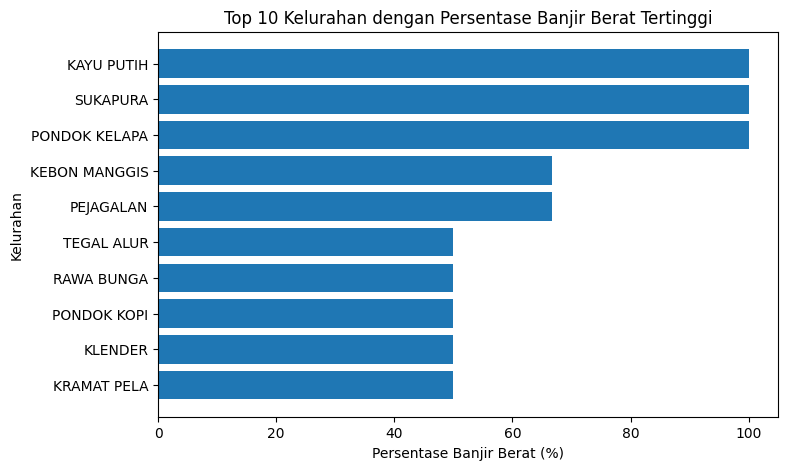

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(
    top_kelurahan['kelurahan'],
    top_kelurahan['persentase_banjir_berat']
)
plt.xlabel('Persentase Banjir Berat (%)')
plt.ylabel('Kelurahan')
plt.title('Top 10 Kelurahan dengan Persentase Banjir Berat Tertinggi')
plt.gca().invert_yaxis()
plt.show()


In [36]:
# Simpan data hasil klasterisasi
df.to_csv(
    'data_banjir_clustered.csv',
    index=False
)


In [37]:
agregasi_kelurahan.to_csv(
    'agregasi_kelurahan.csv',
    index=False
)


In [39]:
import pickle

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [41]:
with open('kmeans_model.pkl', 'rb') as f:
    kmeans_loaded = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler_loaded = pickle.load(f)

print("Model & scaler berhasil di-load")


Model & scaler berhasil di-load


In [42]:
import numpy as np

data_input = np.array([[80, 3, 20, 100, 2]])
# urutan: fitur

data_scaled = scaler_loaded.transform(data_input)
prediksi = kmeans_loaded.predict(data_scaled)

prediksi


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1], dtype=int32)